In [1]:
# attempt at characteristic function evolution for generic drift f(x)
# assume f(x) is periodic on [-\pi, \pi]
# idea: expand f(x) in Fourier series
# then use Fourier coefficients together with generic CFE method for Fourier basis

import numpy as np
import scipy.special as ss
import scipy.signal as sig
import scipy.interpolate as interp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# constant diffusion
g = 0.25

# levy alpha parameter
alpha = 1.0

# time step
h = 0.01

# for stretch = 1, this is an equispaced grid on the closed interval [-lmax, lmax]
# for stretch > 1, this is a way to create a non-equispaced grid on [-lmax, lmax]
#                  that is highly concentrated near the origin
npts = 1025
stretch = 1.0
lmax = 32

du = 2.0/(npts - 1)
startvec = -1.0 + np.arange(npts)*du
uvec = lmax*np.sign(startvec)*(np.abs(startvec)**stretch)

# this is a scaling factor used in all the collocation functions below
zeta = 1.0

In [3]:
# CHARACTERISTIC FUNCTION OF THE CAUCHY PDF,
# looks like an UNNORMALIZED LAPLACE PDF, 
# beautiful but sadly non-differentiable at the origin
def xi(u):
    return np.exp(-np.abs(u/zeta))

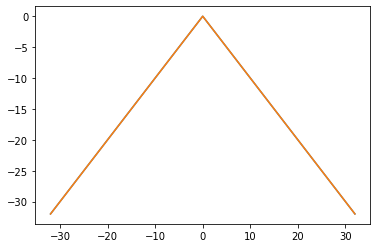

In [4]:
# comparing, on a log scale, our chosen collocation function versus the unnormalized Laplace
plt.plot(uvec, np.log(xi(uvec)))
plt.plot(uvec, -np.abs(uvec/zeta))

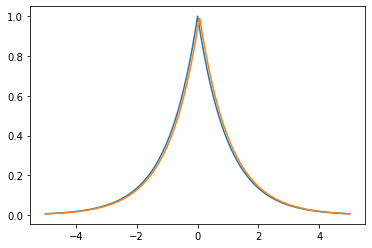

In [5]:
# checking to see how much overlap we have on our grid in u space
uuvec = np.linspace(-5,5,401)
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 0]))
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 1]))

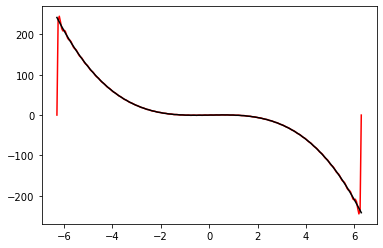

In [6]:
# all the matrices are defined in the notes
udiffmat = (np.expand_dims(uvec,0) - np.expand_dims(uvec,0).T)
JJ = 200
L = 2
ximats = np.zeros((4*JJ+1, npts, npts))
for j in range(4*JJ+1):
    ximats[j, :, :] = xi(udiffmat + j/L - 2*JJ/L)
    
# set up true Fourier coefficients
coefs = np.zeros(2*JJ+1, dtype=np.complex128)
for j in range(-JJ, JJ+1):
    if j != 0:
        coefs[j+JJ] = -1j*(-1)**j * L * (-6*L**2 + j**2 * (-1 + L**2 * np.pi**2))/j**3

# for j in range(-JJ, JJ+1):
#     coefs[j+JJ] = 4*L*np.exp(-np.pi*(1j*j + 2*L**2*np.pi))*(np.exp(2j*j*np.pi)-1)
#     prefac = 1j*np.exp(-j**2/(8*L**2))*j*np.sqrt(2*np.pi)
#     coefs[j+JJ] += prefac*ss.erf((1j*j - 4*L**2*np.pi)/(2*L*np.sqrt(2)))
#     coefs[j+JJ] -= prefac*ss.erf((1j*j + 4*L**2*np.pi)/(2*L*np.sqrt(2)))
#     coefs[j+JJ] /= (-32*L**2*np.pi)

# coefs *= 10


# check what these coefficients give
xmax = L*np.pi
xpts = 256
xvec = np.linspace(-xmax, xmax, xpts)
testfn = np.zeros(xpts, dtype=np.complex128)
for j in range(-JJ, JJ+1):
    testfn += coefs[j+JJ]*np.exp(1j*j*xvec/L)

plt.plot(xvec, np.real(testfn), color='red')
plt.plot(xvec, xvec - xvec**3, color='black')
plt.show()

a = (1+0j)*ximats[2*JJ]
d = (1+0j)*np.diag(np.exp(-h*np.abs(uvec*g)**alpha))

b = 1j*h*np.einsum('i,ijk->jk',coefs, ximats[JJ:(3*JJ+1),:,:] ) @ np.diag(uvec)
convcoefs = sig.convolve(coefs, coefs)
b += -0.5*h**2*np.einsum('i,ijk->jk',convcoefs, ximats) @ np.diag(uvec**2)

# operator splitting
propagator = np.linalg.inv(a - d @ b.T) @ d @ a

In [7]:
# check stability of propagator
# np.max(np.abs(np.linalg.eig(propagator)[0]))

C:\Users\haris\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


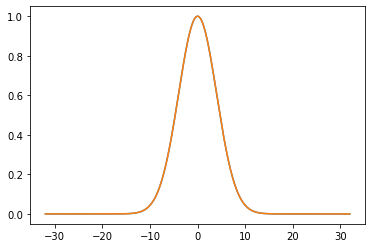

In [8]:
# set up initial condition, a mean-zero Gaussian (characteristic function)
initvar = 0.25
psi0 = np.exp(-(initvar**2/2)*uvec**2)

# represent initial condition using collocation functions
gamma = np.linalg.inv(a) @ psi0

# check to see how well we can reconstruct the initial condition 
plt.plot(uvec, a @ gamma)
plt.plot(uvec, psi0)
plt.show()


In [9]:
# set up time stepping
# store all the characteristic functions
numsteps = 400
gammamat = np.zeros((npts, numsteps+1))
gammamat[:, 0] = gamma

for iii in range(numsteps):
    gammamat[:, iii+1] = propagator @ gammamat[:, iii]
    normalization = a[(npts-1)//2, :] @ gammamat[:, iii+1]
    print(normalization)
    
    # forcefully renormalized at every time step
    # we'd like to avoid doing this, as this is a total hack:
    # gammamat[:, iii+1] /= normalization
    # print( a[(npts-1)//2, :] @ gammamat[:, iii+1] )


C:\Users\haris\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
C:\Users\haris\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


(1.000000000000021+0j)
(1.0000000000000249+0j)
(1.0000000000000289+0j)
(1.0000000000000324+0j)
(1.0000000000000357+0j)
(1.0000000000000393+0j)
(1.0000000000000426+0j)
(1.0000000000000453+0j)
(1.0000000000000493+0j)
(1.000000000000053+0j)
(1.0000000000000564+0j)
(1.0000000000000595+0j)
(1.0000000000000628+0j)
(1.0000000000000662+0j)
(1.0000000000000697+0j)
(1.0000000000000733+0j)
(1.0000000000000766+0j)
(1.0000000000000806+0j)
(1.000000000000084+0j)
(1.0000000000000873+0j)
(1.0000000000000904+0j)
(1.0000000000000935+0j)
(1.0000000000000968+0j)
(1.0000000000001004+0j)
(1.0000000000001037+0j)
(1.000000000000108+0j)
(1.000000000000111+0j)
(1.0000000000001137+0j)
(1.0000000000001172+0j)
(1.0000000000001208+0j)
(1.0000000000001243+0j)
(1.0000000000001275+0j)
(1.0000000000001301+0j)
(1.000000000000134+0j)
(1.0000000000001368+0j)
(1.0000000000001399+0j)
(1.0000000000001432+0j)
(1.000000000000146+0j)
(1.0000000000001497+0j)
(1.0000000000001525+0j)
(1.0000000000001559+0j)
(1.000000000000159+0j)


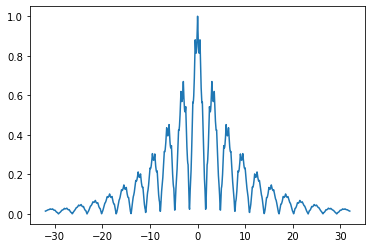

In [10]:
# plot characteristic function at final time step
plt.plot(uvec,np.abs(a @ gammamat[:, numsteps]))

In [22]:
xmax = 10
xpts = 4000
xvec = np.linspace(-xmax, xmax, xpts)
ftmat = np.exp(-1j * np.expand_dims(uvec,1) @ np.expand_dims(xvec, 0))

# going backwards from the characteristic function to the Cauchy PDF,
# with scaling factor zeta included:
base = zeta/(np.pi*(1.0 + zeta**2*xvec**2))

# going backwards for Charbonnier -- no closed-form inverse Fourier transform
# had to do this numerically in Mathematica
# base = np.loadtxt('charboninv.csv')

# going backwards for my homegrown smoothing of the Laplace
# had to do this numerically in Mathematica
# base = np.loadtxt('myfuncinv.csv')

# going backwards from our C^2 homegrown polynomials, again
# with scaling factor zeta included
# base = (1.0-np.cos(xvec*zeta))/(np.pi*xvec**2*zeta)

# reconstruct PDF from final characteristic function
mypdf = np.real(gammamat[:, numsteps] @ ftmat) * base

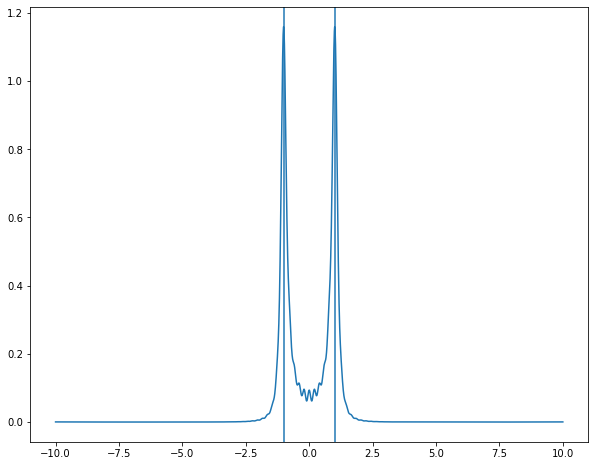

In [23]:
plt.figure(figsize=(10,8))
plt.plot(xvec, mypdf)
plt.axvline(x=1)
plt.axvline(x=-1)
plt.savefig('genpdfDec16.png')

In [24]:
# b = a - h*dxi(udiffmat) @ np.diag(uvec) + 0.5 * h**2 * ddxi(udiffmat) @ np.diag(uvec**2)


In [25]:
np.trapz(mypdf,xvec)

0.9027812746016264

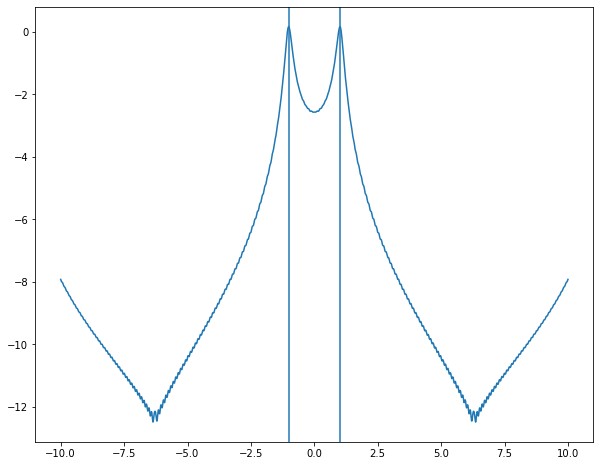

In [48]:
plt.figure(figsize=(10,8))
plt.plot(xvec, np.log(mypdf))
plt.axvline(x=1)
plt.axvline(x=-1)
plt.savefig('genlogpdf.png')